# Subset the IS2 and Lidar data for point cloud alignment

In [18]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from astropy.time import Time
from datetime import datetime
import rasterio as rio
from rasterio import features
from rasterio.plot import show
import rasterio.windows
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import rioxarray as rxr
from shapely.geometry import Polygon
from shapely.geometry import mapping

In [19]:
%matplotlib inline

In [20]:
atl06sr_snowoff_fn = '../data/methow_snowoff_sr-atl0604272022_32610.geojson'
atl06sr_snowoff = gpd.read_file(atl06sr_snowoff_fn) #, geometry=gpd.points_from_xy(atl06sr_snowoff.x, atl06sr_snowoff.y)

In [4]:
atl06sr_snowoff.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

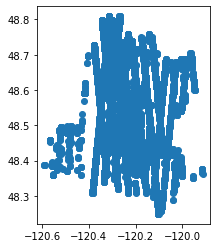

In [52]:
atl06sr_snowoff.plot()

In [7]:
atl06sr_snowoff.head()

,x,y,z,geometry
0,-120.5514889,48.35915778,2064.199461,None
1,-120.5515161,48.35933674,2054.374982,None
2,-120.5515433,48.35951602,2046.90207,None
3,-120.5515706,48.3596953,2041.548979,None
4,-120.551598,48.35987457,2039.899003,None


In [21]:
asp_area_fn = '../data/asp_area.geojson'
asp_area = gpd.read_file(asp_area_fn)

In [22]:
asp_area = asp_area.to_crs('epsg:32610')

<AxesSubplot:>

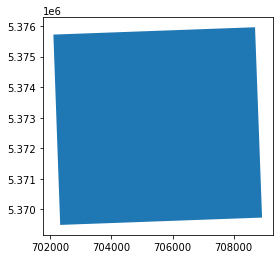

In [68]:
asp_area.plot()

In [7]:
asp_area.bounds

,minx,miny,maxx,maxy
0,702103.278184,5.369496e+06,708926.081779,5.375959e+06


In [23]:
bounds = [(702103.278184, 5.369496e+06), (702103.278184, 5.375959e+06), (708926.081779, 5.375959e+06), (708926.081779, 5.369496e+06), (702103.278184, 5.369496e+06)]
polygon = Polygon([(702103.278184, 5.369496e+06), (702103.278184, 5.375959e+06), (708926.081779, 5.375959e+06), (708926.081779, 5.369496e+06), (702103.278184, 5.369496e+06)])

In [24]:
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=atl06sr_snowoff.crs)

In [11]:
poly_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

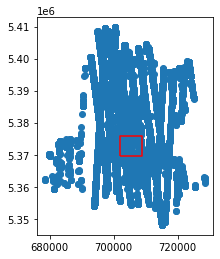

In [12]:
fig, ax = plt.subplots()

atl06sr_snowoff.plot(ax = ax)
poly_gdf.boundary.plot(ax = ax, color="red")

In [13]:
type(atl06sr_snowoff)

geopandas.geodataframe.GeoDataFrame

In [25]:
snowoff_subset = gpd.clip(atl06sr_snowoff, poly_gdf)

<AxesSubplot:>

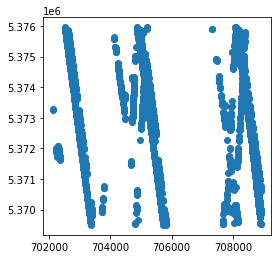

In [14]:
snowoff_subset.plot()

In [68]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_statewide/SlideRule_methow/notebooks


In [69]:
snowoff_subset.to_csv('../data/methow_snowoff_subset_05102022.csv')

### Using rasterio windows to open the dataset within certain bounds, from David's GDA notebook: 05 Raster1 Part 2.  
This allows me to save on computation time, since the full 1m resolution dataset is huge.

In [11]:
dnr_fn = '../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_32610_1m.tif'
dnr_fn_10m = '../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_32610_10m.tif'

In [70]:
first = rio.open(dnr_fn_10m)

In [71]:
first.shape

(6393, 5464)

In [72]:
a = first.read(1)

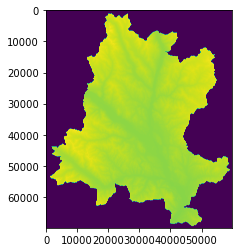

In [15]:
# This took forever to run since the dataset (1m version) is huge. Don't rerun this cell

# plt.imshow(a)

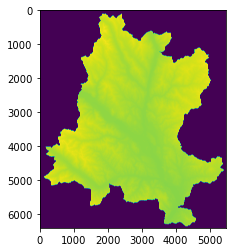

In [73]:
# plotting the 10m version, happens very quickly.
plt.imshow(a)

In [23]:
asp_area.bounds

,minx,miny,maxx,maxy
0,702103.278184,5.369496e+06,708926.081779,5.375959e+06


In [26]:
left = 702103.278184
bottom = 5.369496e+06
right = 708926.081779
top = 5.375959e+06

In [44]:
# bottom = bounds[0] 
# left = bounds[1] 
# top = bounds[2]
# right = bounds[3]

In [57]:
# fig, ax = plt.subplots()
# ax.scatter(left[0], left[1], c = 'b')
# ax.scatter(bottom[0], bottom[1], c = 'r')
# ax.scatter(right[0], right[1], c = 'g')
# ax.scatter(top[0], top[1], c = 'k')

In [74]:
#Define window bounds
window = rasterio.windows.from_bounds(left, bottom, right, top, transform = first.transform)
window_bounds = rasterio.windows.bounds(window, transform = first.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (702103.278184, 5369496.0, 708926.0817790001, 5375959.0)
Window extent:  [702103.278184, 708926.0817790001, 5369496.0, 5375959.0]


In [75]:
first.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 5464,
 'height': 6393,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(10.0, 0.0, 677242.4233203284,
        0.0, -10.0, 5410675.553823955)}

In [76]:
with rio.open(dnr_fn_10m) as src:
    subset = src.read(1, window=window, masked=True)

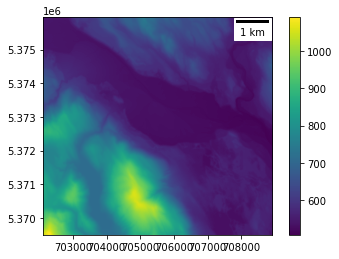

In [77]:
f,ax = plt.subplots()
plt.imshow(subset, extent=window_extent)
plt.colorbar()
ax.add_artist(ScaleBar(1));

## Save just this subset of the original data to a new file  
Followed the example under 'Writing Rasters' from https://geobgu.xyz/py/rasterio.html

In [78]:
with rio.open('../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_subset_32610_10m.tif', 
            'w', 
             driver='GTiff',
             width = subset.shape[1],
             height = subset.shape[0],
             count = 1,
             dtype = subset.dtype,
             crs = first.crs,
             transform = rasterio.windows.transform(window,first.transform)) as src:      #rasterio.windows.transform(window, 
    #a = src.read(1, window=window) # , masked = True
    src.write(subset, 1)

src.close()

In [79]:
new_dataset = rio.open('../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_subset_32610_10m.tif')

In [80]:
new_dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 682,
 'height': 646,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(10.0, 0.0, 702103.278184,
        0.0, -10.0, 5375959.0)}

In [81]:
dataset = new_dataset.read(1)

<AxesSubplot:>

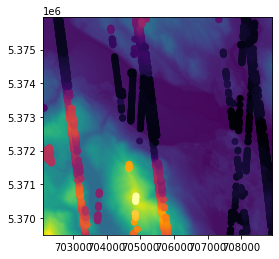

In [82]:
fig, ax = plt.subplots()
plt.imshow(dataset, extent=window_extent, cmap = 'viridis')
snowoff_subset.plot(ax=ax, column = 'h_mean', cmap = 'inferno')

In [62]:
snowoff_subset.head()

,time,distance,dh_fit_dx,gt,spot,w_surface_window_final,h_mean,dh_fit_dy,n_fit_photons,pflags,...,rgt,rms_misfit,delta_time,segment_id,doy,decyear,dowy,x,y,geometry
2651,2019-07-11T10:32:34.456001,5.393364e+06,-0.114818,30,3,3.323157,545.699684,0.0,38,0,...,204,0.413242,4.807635e+07,268965,192,2019.524491,284,708923.716437,5.369871e+06,POINT (708923.716 5369870.791)
2666,2019-07-11T10:32:34.464001,5.393424e+06,0.112368,30,3,3.000000,548.401161,0.0,38,4,...,204,0.668441,4.807635e+07,268968,192,2019.524491,284,708916.184999,5.369928e+06,POINT (708916.185 5369928.356)
2672,2019-07-11T10:32:34.467999,5.393444e+06,0.063198,30,3,3.000000,549.993829,0.0,41,0,...,204,0.368122,4.807635e+07,268969,192,2019.524491,284,708913.304749,5.369950e+06,POINT (708913.305 5369950.261)
2678,2019-07-11T10:32:34.470001,5.393464e+06,0.026612,30,3,3.000000,550.890509,0.0,44,0,...,204,0.259753,4.807635e+07,268970,192,2019.524491,284,708910.702647,5.369970e+06,POINT (708910.703 5369970.129)
2684,2019-07-11T10:32:34.473000,5.393485e+06,-0.033597,30,3,3.000000,550.920552,0.0,29,0,...,204,0.334331,4.807635e+07,268971,192,2019.524491,284,708908.117759,5.369990e+06,POINT (708908.118 5369989.999)


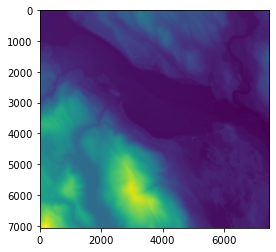

In [55]:
plt.imshow(dataset)